In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import math

# Environment

#### Noisy Cart Pole

This is the noisy version of the CartPole-v0 environment of OpenAI.  
https://gym.openai.com/envs/CartPole-v0  
https://github.com/openai/gym/wiki/CartPole-v0  

In [2]:
class NoisyCartPoleEnvironment:
    
    stateDimension = 4
    actionDimension = 1
    actionSpace = range(2)
    transitionSigmas = [ 0.1, 0.01, 0.1, 0.01 ]
    
    def __init__(self):
        pass
    
    def cartpole_reset(self):
        state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        return np.array(state)
    
    # Extracted from OpenAI environment CartPole-v0
    def cartpole_step(self, state, action):

        gravity = 9.8
        masscart = 1.0
        masspole = 0.1
        total_mass = (masspole + masscart)
        length = 0.5 # actually half the pole's length
        polemass_length = (masspole * length)
        force_mag = 10.0
        tau = 0.02  # seconds between state updates

        # Angle at which to fail the episode
        theta_threshold_radians = 12 * 2 * math.pi / 360
        x_threshold = 2.4

        x, x_dot, theta, theta_dot = state

        already_done =  x < -x_threshold \
            or x > x_threshold \
            or theta < -theta_threshold_radians \
            or theta > theta_threshold_radians
        already_done = bool(already_done)

        if already_done:

            next_state = state
            reward = 0
            done = True

        else:

            force = force_mag if action==1 else -force_mag
            costheta = math.cos(theta)
            sintheta = math.sin(theta)
            temp = (force + polemass_length * theta_dot * theta_dot * sintheta) / total_mass
            thetaacc = (gravity * sintheta - costheta* temp) / (length * (4.0/3.0 - masspole * costheta * costheta / total_mass))
            xacc  = temp - polemass_length * thetaacc * costheta / total_mass
            x  = x + tau * x_dot
            x_dot = x_dot + tau * xacc
            theta = theta + tau * theta_dot
            theta_dot = theta_dot + tau * thetaacc
            next_state = np.array([x,x_dot,theta,theta_dot])

            reward = 1

            done =  x < -x_threshold \
                or x > x_threshold \
                or theta < -theta_threshold_radians \
                or theta > theta_threshold_radians
            done = bool(done)

        return next_state, reward, done, {}
    
    def noisycartpole_reset(self):
        return self.cartpole_reset()

    def noisycartpole_step(self, state, action):

        next_state_mean, reward, done, info = self.cartpole_step(state, action)   # CartPole Step

        noise = np.zeros(self.stateDimension)
        if not done:
            noise = np.random.randn(self.stateDimension) * self.transitionSigmas        # Adding Noise
        next_state = next_state_mean + noise

        logp = multivariate_normal.logpdf(next_state, mean=next_state_mean, cov=np.diagflat(self.transitionSigmas))

        return next_state, reward, done, logp
    
    def reset(self):
        return self.noisycartpole_reset()
    
    def step(self, state, action):
        return self.noisycartpole_step(state, action)
    

In [3]:
env = NoisyCartPoleEnvironment()

# Policy

In [4]:
class SciKitPolicy():

    def __init__(self):
        raise NotImplementedError()

    def query(self, states):
        if len(states.shape) == 1:
            states = states.reshape(1, -1)
        return self.method.predict(states)

    def train(self, inputs, targets):
        self.method.fit(inputs, targets)

    def m_step(self, states, actions):

        # States/Actions -> Inputs/Targets
        inputs, targets = trajectory2tuples(states, actions)

        # Train kNN
        self.train(inputs, targets.ravel())

In [5]:
class KnnPolicyDiscrete(SciKitPolicy):
    def __init__(self, k, weights='distance'):
        self.method = KNeighborsClassifier(n_neighbors=k, weights=weights, n_jobs=1)

In [6]:
class UniformPolicyDiscrete():

    def __init__(self, choices):
        self.choices = choices

    def query(self, states):
        return np.random.choice(self.choices, size=states.shape[0]), np.zeros(states.shape[0]) 

# Utility Functions

In [7]:
def rollout_trajectories(env, policy, horizon, sample_count=1):

    # States and Actions
    states = np.zeros((sample_count, horizon, env.stateDimension))
    actions = np.zeros((sample_count, horizon, env.actionDimension))
    rewards = np.zeros((sample_count, horizon))
    logp = np.zeros(sample_count)
    
    # Sample Trajectories
    for t in range(horizon):
        
        logp_step_transition = np.zeros((sample_count))
        
        # Initialization
        if t == 0:
            states[:,t,:] = [ env.reset() for i in range(sample_count) ]
            
        # Transition and Reward
        else:
            for s in range(sample_count):
                states[s, t, :], rewards[s,t-1], _1, logp_step_transition[s] = env.step(states[s, t-1, :], actions[s, t-1, :])
        
        # Action Selection
        actions_unshaped, logp_step_policy = policy.query(states[:, t, :])
        actions[:,t,:] = actions_unshaped.reshape(sample_count, env.actionDimension)
        
        # Log Probability of Sampling
        logp += logp_step_transition + logp_step_policy
        
    for s in range(sample_count):
        _, rewards[s, horizon-1], _1, _2 = env.step(states[s, horizon-1, :], actions[s, horizon-1, :])

    return states, actions, rewards, logp

In [8]:
def plot_trajectories(states, color='red', n=0):

    [sample_count, _, _] = states.shape

    if n==0:
        samples_drawn = range(sample_count)
    else:
        samples_drawn = np.random.choice(sample_count, n)
        
    for s in samples_drawn:
        plt.plot(states[s, :, 0], states[s, :, 2], '-', color=color)
        plt.plot(states[s, :, 0], states[s, :, 2], 'o', color=color, markersize=2)
        plt.plot(states[s, -1, 0], states[s, -1, 2], 'o', color=color, markersize=5)

In [9]:
def plot_iteration(states, rewards, selected=None, n=0):
    plot_trajectories(states, color='red', n=n)
    if selected is not None:
        plot_trajectories(selected, color='green', n=n)
    
    plt.vlines(0, -0.25, 0.25, linestyle='dotted')
    # plt.vlines(2.4, -0.25, 0.25, linestyle='dotted')
    # plt.vlines(-2.4, -0.25, 0.25, linestyle='dotted')
    
    plt.hlines(0, -2.4, 2.4, linestyle='dotted')
    plt.hlines(0.21, -2.4, 2.4, linestyle='dotted')
    plt.hlines(-0.21, -2.4, 2.4, linestyle='dotted')
    
    plt.grid()
    plt.xlabel('Average Reward : ' + str(np.sum(rewards) / sample_count))
    plt.show()

# Sampling a Trajectory from Prior

In [10]:
# Parameters
horizon = 20
sample_count = 10

In [11]:
states, actions,rewards, logp = \
            rollout_trajectories(env, UniformPolicyDiscrete(env.actionSpace), horizon, sample_count)

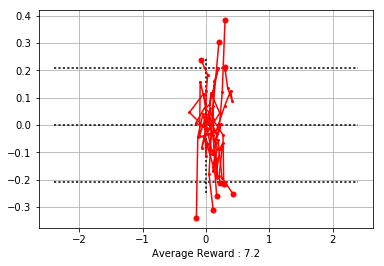

In [12]:
plot_iteration(states, rewards)
plt.show()

In [13]:
logp

array([ 60.78943531,  60.85861964,  59.22664488,  60.56146572,
        60.96423351,  60.98031699,  60.90170527,  60.96845373,
        61.0255222 ,  60.50396076])